In [41]:
import pandas as pd
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import f_regression, SelectKBest, RFE 
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt 

import wrangle as w

import warnings
warnings.filterwarnings('ignore')

1. Select a dataset with a continuous target variable.

2. Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.

3. Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.



In [2]:
df = w.wrangle_zillow()
df.head()

,bedrooms,bathrooms,sq_ft,fips,year_built,tax_amount,tax_value
0,4.0,2.0,3633.0,6037.0,2005.0,6941.39,296425.0
1,3.0,4.0,1620.0,6037.0,2011.0,10244.94,847770.0
2,3.0,2.0,2077.0,6037.0,1926.0,7924.68,646760.0
3,3.0,1.0,1244.0,6037.0,1950.0,2532.88,169471.0
4,3.0,2.0,1300.0,6037.0,1950.0,3110.99,233266.0


In [3]:
train, validate, test = w.train_val_test(df)

train.shape, validate.shape, test.shape

((1455615, 7), (727807, 7), (727808, 7))

In [4]:
train_scaled, validate_scaled, test_scaled = w.scaled_data(train, validate, test)

train_scaled.shape, validate_scaled.shape, test_scaled.shape

((1455615, 7), (727807, 7), (727808, 7))

In [6]:
train_scaled.head()

,bedrooms,bathrooms,sq_ft,fips,year_built,tax_amount,tax_value
553891,0.6,0.4,0.320984,6037.0,1981.0,0.044565,318856.0
863544,0.6,0.4,0.198704,6059.0,1964.0,0.037534,279877.0
682472,0.4,0.2,0.142018,6037.0,1923.0,0.013778,92106.0
865965,0.6,0.2,0.184735,6111.0,1970.0,0.017125,111459.0
718183,0.0,0.2,0.125822,6059.0,1967.0,0.025234,164846.0


In [9]:
X_train_scaled = train_scaled[['bedrooms','bathrooms','sq_ft', 'tax_amount']]
y_train = train_scaled['tax_value']

In [13]:
train_scaled.head(3)

,bedrooms,bathrooms,sq_ft,fips,year_built,tax_amount,tax_value
553891,0.6,0.4,0.320984,6037.0,1981.0,0.044565,318856.0
863544,0.6,0.4,0.198704,6059.0,1964.0,0.037534,279877.0
682472,0.4,0.2,0.142018,6037.0,1923.0,0.013778,92106.0


In [26]:
X_train = train_scaled.drop(columns = ['tax_value','year_built'])
X_train.head()

,bedrooms,bathrooms,sq_ft,fips,tax_amount
553891,0.6,0.4,0.320984,6037.0,0.044565
863544,0.6,0.4,0.198704,6059.0,0.037534
682472,0.4,0.2,0.142018,6037.0,0.013778
865965,0.6,0.2,0.184735,6111.0,0.017125
718183,0.0,0.2,0.125822,6059.0,0.025234


In [27]:
X_train = pd.get_dummies(X_train, columns = ['fips'])
X_train.head()

,bedrooms,bathrooms,sq_ft,tax_amount,fips_6037.0,fips_6059.0,fips_6111.0
553891,0.6,0.4,0.320984,0.044565,1,0,0
863544,0.6,0.4,0.198704,0.037534,0,1,0
682472,0.4,0.2,0.142018,0.013778,1,0,0
865965,0.6,0.2,0.184735,0.017125,0,0,1
718183,0.0,0.2,0.125822,0.025234,0,1,0


In [17]:
def select_kbest(x,y,k):
    
    f_selector = SelectKBest(f_regression, k = k)
    
    f_selector.fit(x, y)   
    
    f_select_mask = f_selector.get_support()

    f_selector.transform(x)
    
    
    return x.iloc[:,f_select_mask]

In [28]:
select_kbest(X_train_scaled, y_train, 2)

,sq_ft,tax_amount
553891,0.320984,0.044565
863544,0.198704,0.037534
682472,0.142018,0.013778
865965,0.184735,0.017125
718183,0.125822,0.025234
...,...,...
549220,0.150319,0.025709
162752,0.329790,0.167441
1012524,0.157506,0.031676
1300612,0.267132,0.052543


In [8]:
def rfe(x, y, k):
    
    lm = LinearRegression()

    rfe = RFE(lm, n_features_to_select = k)
    
    rfe.fit(x, y)
    
    ranks = rfe.ranking_

    columns = x.columns.tolist()
    
    feature_ranks = pd.DataFrame({'ranking': ranks,
                                 'feature': columns})
    
    return feature_ranks.sort_values('ranking').reset_index().drop(columns = ('index'))

In [32]:
rfe(X_train, y_train, 5)

,ranking,feature
0,1,sq_ft
1,1,tax_amount
2,1,fips_6037.0
3,1,fips_6059.0
4,1,fips_6111.0
5,2,bedrooms
6,3,bathrooms


In [35]:
lm = LinearRegression()

lm.fit(X_train, y_train)

LinearRegression()

In [37]:
X_train.head(3)

,bedrooms,bathrooms,sq_ft,tax_amount,fips_6037.0,fips_6059.0,fips_6111.0
553891,0.6,0.4,0.320984,0.044565,1,0,0
863544,0.6,0.4,0.198704,0.037534,0,1,0
682472,0.4,0.2,0.142018,0.013778,1,0,0


In [38]:
lm_preds = lm.predict(X_train)

In [39]:
preds_df = pd.DataFrame({'actual': y_train,
                         'lm_preds': lm_preds})
preds_df.head()

,actual,lm_preds
553891,318856.0,326900.625
863544,279877.0,295775.750
682472,92106.0,80979.250
865965,111459.0,148323.375
718183,164846.0,213943.500


In [42]:
lm_rmse = sqrt(mean_squared_error(preds_df['lm_preds'], preds_df['actual']))
lm_rmse

64965.062216765094

In [82]:
lasso = LassoLars(alpha = 0.05)

In [83]:
lasso.fit(X_train, y_train)

LassoLars(alpha=0.05)

In [84]:
lasso_preds = lasso.predict(X_train)

In [85]:
preds_df['lasso_preds'] = lasso_preds
preds_df.head()

,actual,lm_preds,lasso_preds,tweedie,tweedie_two,baseline
553891,318856.0,326900.625,326731.710396,399590.721185,352685.973003,399191.596623
863544,279877.0,295775.750,296017.622853,423513.120361,338572.111723,399191.596623
682472,92106.0,80979.250,81158.146095,388716.214219,223567.424627,399191.596623
865965,111459.0,148323.375,148103.084110,406365.945388,269866.886119,399191.596623
718183,164846.0,213943.500,213871.100791,408855.061694,282212.966821,399191.596623


In [86]:
lasso_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['lasso_preds']))
lasso_rmse

64965.47420897749

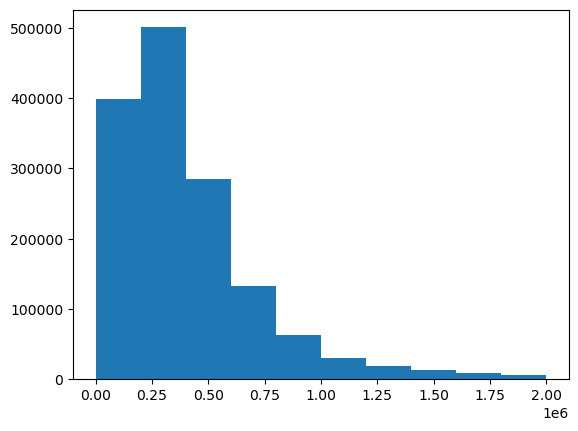

In [64]:
plt.hist(y_train)
plt.show()

In [65]:
tweedie = TweedieRegressor(power = 0)

tweedie.fit(X_train, y_train)

TweedieRegressor(power=0)

In [66]:
preds_df['tweedie'] = tweedie.predict(X_train)

preds_df

,actual,lm_preds,lasso_preds,tweedie
553891,318856.0,326900.625,3.265680e+05,399590.721185
863544,279877.0,295775.750,2.962826e+05,423513.120361
682472,92106.0,80979.250,8.132531e+04,388716.214219
865965,111459.0,148323.375,1.479176e+05,406365.945388
718183,164846.0,213943.500,2.137621e+05,408855.061694
...,...,...,...,...
549220,189635.0,171819.750,1.720671e+05,388975.577400
162752,1345806.0,1249710.875,1.249737e+06,406463.266794
1012524,231164.0,217636.250,2.178083e+05,389147.563453
1300612,421439.0,413247.000,4.129809e+05,424754.189419


In [67]:
tweedie_norm = sqrt(mean_squared_error(preds_df.actual, preds_df.tweedie))

tweedie_norm

307972.5439452428

In [68]:
tweedie_two = TweedieRegressor(power = 1)

tweedie_two.fit(X_train, y_train)

preds_df['tweedie_two'] = tweedie_two.predict(X_train)

In [69]:
tweedie_possion = sqrt(mean_squared_error(preds_df.actual, preds_df.tweedie_two))
tweedie_possion

1865067.162516936

In [97]:
pf = PolynomialFeatures(degree = 2)

pf.fit(X_train, y_train)

PolynomialFeatures()

In [98]:
X_polynomial = pf.transform(X_train)

In [99]:
lm2 = LinearRegression()

lm2.fit(X_polynomial, y_train)

LinearRegression()

In [100]:
preds_df['poly_preds'] = lm2.predict(X_polynomial)

preds_df.head()

,actual,lm_preds,lasso_preds,tweedie,tweedie_two,baseline,poly_preds
553891,318856.0,326900.625,324956.868341,399590.721185,352685.973003,399191.596623,308498.0
863544,279877.0,295775.750,298646.440492,423513.120361,338572.111723,399191.596623,294660.0
682472,92106.0,80979.250,83284.259149,388716.214219,223567.424627,399191.596623,72304.0
865965,111459.0,148323.375,145885.061166,406365.945388,269866.886119,399191.596623,141160.0
718183,164846.0,213943.500,209241.124201,408855.061694,282212.966821,399191.596623,208704.0


In [101]:
poly_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['poly_preds']))

poly_rmse

63633.44678560559

In [102]:
lasso_two = LassoLars(alpha = .1)

lasso_two.fit(X_polynomial, y_train)

LassoLars(alpha=0.1)

In [103]:
preds_df['lasso_poly'] = lasso_two.predict(X_polynomial)

preds_df

,actual,lm_preds,lasso_preds,tweedie,tweedie_two,baseline,poly_preds,lasso_poly
553891,318856.0,326900.625,3.249569e+05,399590.721185,3.526860e+05,399191.596623,308498.0,3.130811e+05
863544,279877.0,295775.750,2.986464e+05,423513.120361,3.385721e+05,399191.596623,294660.0,2.964875e+05
682472,92106.0,80979.250,8.328426e+04,388716.214219,2.235674e+05,399191.596623,72304.0,7.421103e+04
865965,111459.0,148323.375,1.458851e+05,406365.945388,2.698669e+05,399191.596623,141160.0,1.389969e+05
718183,164846.0,213943.500,2.092411e+05,408855.061694,2.822130e+05,399191.596623,208704.0,1.996724e+05
...,...,...,...,...,...,...,...,...
549220,189635.0,171819.750,1.734927e+05,388975.577400,2.513572e+05,399191.596623,168162.0,1.697052e+05
162752,1345806.0,1249710.875,1.248324e+06,406463.266794,1.123647e+06,399191.596623,1236030.0,1.237074e+06
1012524,231164.0,217636.250,2.188299e+05,389147.563453,2.672387e+05,399191.596623,215644.0,2.170840e+05
1300612,421439.0,413247.000,4.136470e+05,424754.189419,4.068154e+05,399191.596623,424252.0,4.220302e+05


In [104]:
lasso_poly_rmse = sqrt(mean_squared_error(preds_df.actual, preds_df.lasso_poly))

lasso_poly_rmse

63678.87757880828

In [105]:
compare_models = pd.DataFrame({'model': ['linear', 'lasso', 'tweedie_norm', ' tweedie_possion', 'linear_poly', 'lasso_poly'],
              'rmse': [lm_rmse, lasso_rmse, tweedie_norm, tweedie_possion, poly_rmse, lasso_poly_rmse]})

In [106]:
preds_df['baseline'] = y_train.mean()

preds_df.head()

,actual,lm_preds,lasso_preds,tweedie,tweedie_two,baseline,poly_preds,lasso_poly
553891,318856.0,326900.625,324956.868341,399590.721185,352685.973003,399191.596623,308498.0,313081.113021
863544,279877.0,295775.750,298646.440492,423513.120361,338572.111723,399191.596623,294660.0,296487.483872
682472,92106.0,80979.250,83284.259149,388716.214219,223567.424627,399191.596623,72304.0,74211.026762
865965,111459.0,148323.375,145885.061166,406365.945388,269866.886119,399191.596623,141160.0,138996.918810
718183,164846.0,213943.500,209241.124201,408855.061694,282212.966821,399191.596623,208704.0,199672.442140


In [107]:
baseline_rmse = sqrt(mean_squared_error(preds_df.actual, preds_df.baseline))
baseline_rmse

313316.39895920653

In [108]:
compare_models

,model,rmse
0,linear,6.496506e+04
1,lasso,6.504951e+04
2,tweedie_norm,3.079725e+05
3,tweedie_possion,1.865067e+06
4,linear_poly,6.363345e+04
5,lasso_poly,6.367888e+04


In [109]:
compare_models.loc[len(compare_models.index)] = ['baseline', baseline_rmse] 

In [114]:
pd.options.display.float_format = '{:.2f}'.format
compare_models.sort_values('rmse')

,model,rmse
4,linear_poly,63633.45
5,lasso_poly,63678.88
0,linear,64965.06
1,lasso,65049.51
2,tweedie_norm,307972.54
6,baseline,313316.40
3,tweedie_possion,1865067.16


In [95]:
metrics = []



for i in np.arange(0.05, 1, .05):
    
    lasso = LassoLars(alpha = i )
    
    lasso.fit(X_train, y_train)
    
    lasso_preds = lasso.predict(X_train)
    
    preds_df['lasso_preds'] = lasso_preds

    lasso_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['lasso_preds']))
    
    output = {
            'alpha': i,
            'lasso_rmse': lasso_rmse
             }
    
    metrics.append(output)

df = pd.DataFrame(metrics)    
df.sort_values('lasso_rmse')

,alpha,lasso_rmse
0,0.05,64965.474209
1,0.10,64966.719633
2,0.15,64968.795286
3,0.20,64971.701090
4,0.25,64975.436932
5,0.30,64980.002669
6,0.35,64985.398127
7,0.40,64991.623099
8,0.45,64995.675980
9,0.50,64999.330262
